# Quantile Regression Forest (QRF) Baseline with `quantile-forest`

In this notebook I reimplement the Quantile Regression Forest baseline using the `quantile-forest` package maintained by Zillow. This library provides a `RandomForestQuantileRegressor` class that implements quantile regression forests according to Meinshausen (2006). The API is similar to scikit‑learn: after fitting on `X, y` you can call `predict(X, quantiles)` to obtain conditional quantile estimates.

I keep the same rolling evaluation (Train 120 → Cal 24 → Test 6) and the same feature preprocessing pipeline as in my earlier baselines. Quantiles of interest remain {0.10, 0.25, 0.50, 0.75, 0.90}. The notebook outputs row‑level predictions and per‑fold pinball losses to CSV files for downstream analysis.

You’ll need to install the package with `pip install quantile-forest` when running this notebook locally.

## Data loading and preprocessing

I load `features_v1_tail.csv`, sort by `token` and `timestamp`, and separate features from the target. Categorical columns (`token`, `momentum_bucket`, `day_of_week`, `extreme_flag1`, `tail_asym`, `vol_regime`) are one‑hot encoded and numeric columns are passed through. No imputation is applied because missing data have been forward/back‑filled during feature engineering.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_pinball_loss
from tqdm.auto import tqdm
from quantile_forest import RandomForestQuantileRegressor
import os

# Quantiles to predict
quantiles = [0.10, 0.25, 0.50, 0.75, 0.90]


def enforce_monotonicity(q_preds: np.ndarray) -> np.ndarray:
    # Sort each row of predicted quantiles to prevent crossing
    return np.sort(q_preds, axis=1)

c:\Users\james\OneDrive\Documents\GitHub\solana-qrf-interval-forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
feature_path = "features_v1_tail.csv"
if not os.path.exists(feature_path):
    raise FileNotFoundError(f'{feature_path} not found. Place it in the working directory.')

full_df = pd.read_csv(feature_path)
full_df = full_df.sort_values(['token', 'timestamp']).reset_index(drop=True)

target_col = 'return_72h'
feature_cols = [c for c in full_df.columns if c not in [target_col, 'timestamp']]

categorical_cols = [c for c in feature_cols if c in ['token', 'momentum_bucket', 'day_of_week', 'extreme_flag1', 'tail_asym', 'vol_regime']]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numeric_cols)
])

all_preds = []
fold_losses = []

In [3]:
TRAIN_BARS = 120
CAL_BARS = 24
TEST_BARS = 6
STEP = 6

tokens = full_df['token'].unique().tolist()

for token in tqdm(tokens, desc='Tokens'):
    df_tok = full_df[full_df['token'] == token].reset_index(drop=True)
    n_rows = len(df_tok)
    start_idx = 0
    fold_num = 0
    while start_idx + TRAIN_BARS + CAL_BARS + TEST_BARS <= n_rows:
        train_slice = slice(start_idx, start_idx + TRAIN_BARS)
        test_slice = slice(start_idx + TRAIN_BARS + CAL_BARS, start_idx + TRAIN_BARS + CAL_BARS + TEST_BARS)

        train_df = df_tok.iloc[train_slice]
        test_df = df_tok.iloc[test_slice]

        X_train, y_train = train_df[feature_cols], train_df[target_col]
        X_test, y_test = test_df[feature_cols], test_df[target_col]

        qrf = RandomForestQuantileRegressor(n_estimators=1000,
                                            max_depth=None,
                                            min_samples_leaf=10,
                                            max_features='sqrt',
                                            random_state=42,
                                            n_jobs=-1)

        pipeline = Pipeline([
            ('preprocess', preprocessor),
            ('model', qrf)
        ])

        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test, quantiles=quantiles)
        preds = enforce_monotonicity(preds)

        losses = [mean_pinball_loss(y_test, preds[:, i], alpha=q) for i, q in enumerate(quantiles)]

        for idx, true_val in enumerate(y_test):
            row_pred = {'token': token, 'timestamp': test_df.iloc[idx]['timestamp'], 'y_true': true_val}
            for i, q in enumerate(quantiles):
                row_pred[f'pred_q{int(q*100):02d}'] = preds[idx, i]
            all_preds.append(row_pred)

        fold_losses.append({
            'token': token,
            'fold': fold_num,
            **{f'pinball_q{int(q*100):02d}': loss for q, loss in zip(quantiles, losses)}
        })

        fold_num += 1
        start_idx += STEP

Tokens: 100%|██████████| 21/21 [05:45<00:00, 16.44s/it]


In [4]:
preds_df = pd.DataFrame(all_preds)
losses_df = pd.DataFrame(fold_losses)

preds_df.to_csv('qrf_v1_preds.csv', index=False)
losses_df.to_csv('qrf_v1_pinball.csv', index=False)

print('Saved qrf_v1_preds.csv and qrf_v1_pinball.csv to disk.')

Saved qrf_v1_preds.csv and qrf_v1_pinball.csv to disk.


## Discussion

Using Zillow’s `quantile-forest` implementation simplifies quantile prediction because I can directly call `predict(X, quantiles)`. The rest of the pipeline—including one‑hot encoding, rolling splits and pinball loss evaluation—remains unchanged. After running this notebook, I plan to compare the resulting pinball losses and coverage metrics to those from my previous QRF implementations and baseline models.

Potential next steps include adding conformal adjustments, investigating time‑decay weighting, and tuning the forest’s hyperparameters to further improve interval sharpness and calibration.

# Evaluation of QRF v1 and Planning v2

In this notebook I evaluate the performance of my QRF v1 model built using Zillow’s `quantile-forest` implementation and outline improvements for a conformal‑calibrated v2. The evaluation uses the predictions saved in `qrf_v1_preds.csv` and `qrf_v1_pinball.csv` produced by the training notebook. I compute pinball losses, empirical coverage and interval width distributions, and generate illustrative plots. Based on these insights, I sketch the modifications needed to build a sharper and better‑calibrated QRF v2.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load predictions and fold metrics
test_preds = pd.read_csv('qrf_v1_preds.csv')
fold_metrics = pd.read_csv('qrf_v1_pinball.csv')

# Ensure timestamp is datetime for plotting
if not np.issubdtype(test_preds['timestamp'].dtype, np.datetime64):
    test_preds['timestamp'] = pd.to_datetime(test_preds['timestamp'])

print(f"Loaded {len(test_preds)} row‑level predictions and {len(fold_metrics)} fold metrics")

Loaded 3258 row‑level predictions and 543 fold metrics


In [8]:
# Compute mean pinball loss per quantile across all folds
mean_pinball = fold_metrics[[c for c in fold_metrics.columns if c.startswith('pinball_')]].mean()
print('Mean pinball loss by quantile:')
print(mean_pinball)

# Compute empirical coverage of the 80% interval (between 10th and 90th percentile)
y_true = test_preds['y_true']
lower = test_preds['pred_q10']
upper = test_preds['pred_q90']
covered = ((y_true >= lower) & (y_true <= upper)).mean()
print(f"Empirical 80% interval coverage: {covered:.3f}")

# Compute interval widths and summarise
interval_width = upper - lower
print('Interval width summary:')
print(interval_width.describe())

# Save summary statistics to variables for reporting if needed
coverage = covered
width_stats = interval_width.describe()

Mean pinball loss by quantile:
pinball_q10    0.028586
pinball_q25    0.051812
pinball_q50    0.072491
pinball_q75    0.077116
pinball_q90    0.068162
dtype: float64
Empirical 80% interval coverage: 0.865
Interval width summary:
count    3258.000000
mean        0.445846
std         0.551141
min         0.144036
25%         0.252705
50%         0.335794
75%         0.447456
max         9.773329
dtype: float64


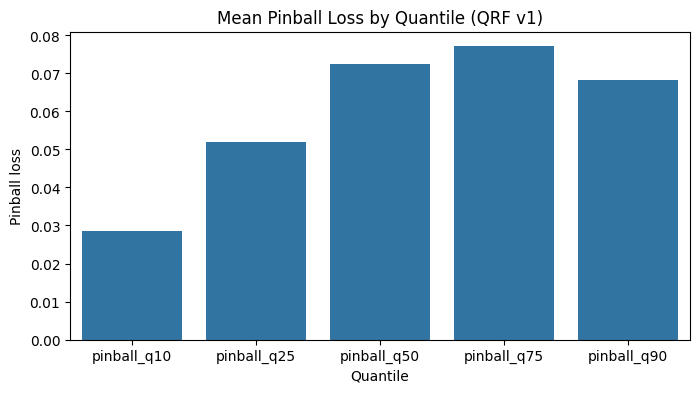

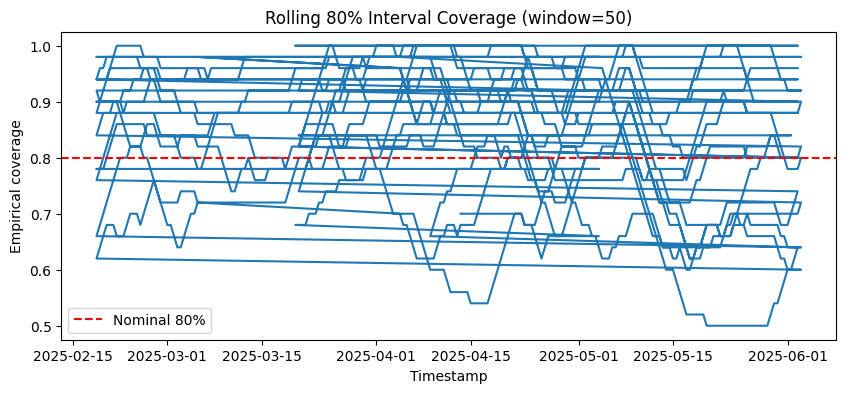

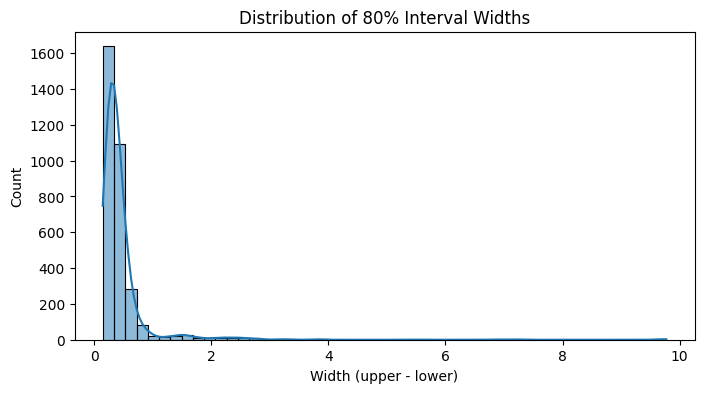

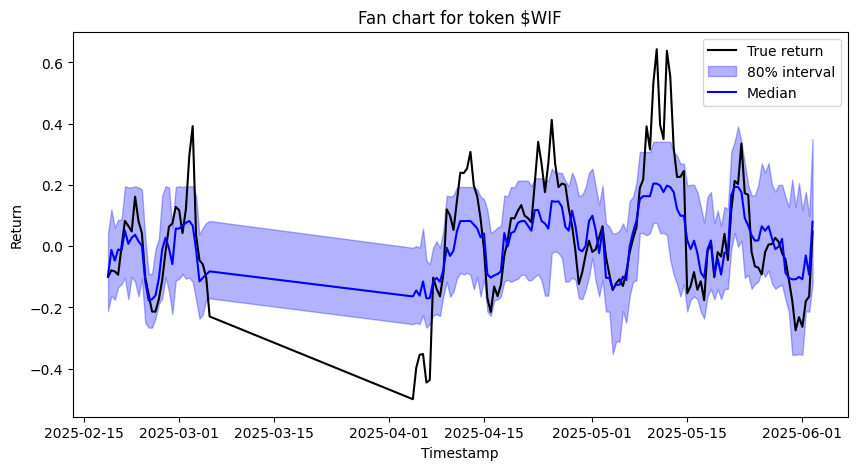

In [ ]:
# Plot pinball loss distribution by quantile
plt.figure(figsize=(8,4))
sns.barplot(x=mean_pinball.index, y=mean_pinball.values)
plt.title('Mean Pinball Loss by Quantile (QRF v1)')
plt.ylabel('Pinball loss')
plt.xlabel('Quantile')
plt.show()

# Plot coverage over time (rolling window of 50 observations)
window = 50
rolling_coverage = ((y_true >= lower) & (y_true <= upper)).rolling(window).mean()
plt.figure(figsize=(10,4))
plt.plot(test_preds['timestamp'], rolling_coverage)
plt.axhline(0.80, color='red', linestyle='--', label='Nominal 80%')
plt.title('Rolling 80% Interval Coverage (window=50)')
plt.ylabel('Empirical coverage')
plt.xlabel('Timestamp')
plt.legend()
plt.show()

# Plot interval width distribution
plt.figure(figsize=(8,4))
sns.histplot(interval_width, bins=50, kde=True)
plt.title('Distribution of 80% Interval Widths')
plt.xlabel('Width (upper - lower)')
plt.ylabel('Count')
plt.show()

# Example fan chart for a single token
example_token = test_preds['token'].iloc[0]
tok_df = test_preds[test_preds['token'] == example_token].sort_values('timestamp')
plt.figure(figsize=(10,5))
plt.plot(tok_df['timestamp'], tok_df['y_true'], label='True return', color='black')
plt.fill_between(tok_df['timestamp'], tok_df['pred_q10'], tok_df['pred_q90'], color='blue', alpha=0.3, label='80% interval')
plt.plot(tok_df['timestamp'], tok_df['pred_q50'], label='Median', color='blue')
plt.title(f'Fan chart for token {example_token}')
plt.xlabel('Timestamp')
plt.ylabel('Return')
plt.legend()
plt.show()

## QRF v1 — Summary & quick comparison

**Setup.** Rolling blocked CV per token (train=120 bars, calibration gap=24, test=6, step=6).
Model: `RandomForestQuantileRegressor` (n=1000, min\_samples\_leaf=10, max\_features=√p) inside a preprocessing pipeline. Quantiles: τ ∈ {0.10, 0.25, 0.50, 0.75, 0.90}. Monotonicity enforced post-hoc.

### Headline results (aggregate over all folds/tokens)

* **Pinball loss (lower is better):**

  * τ=0.10: **0.0286**
  * τ=0.25: **0.0518**
  * τ=0.50: **0.0725**
  * τ=0.75: **0.0771**
  * τ=0.90: **0.0682**
* **Empirical 80% interval coverage:** **86.5%** (over-coverage → intervals are conservative).
* **Interval width (q90–q10) distribution:** mean **0.446**, median **0.336**; heavy right tail (max 9.77) consistent with volatility spikes.

### Comparison to LightGBM v4 (residual-based intervals)

| τ    |     QRF v1 |    LGBM v4 | Δ (QRF–LGBM) |        Δ % |
| ---- | ---------: | ---------: | -----------: | ---------: |
| 0.10 | **0.0286** |     0.0316 |  **−0.0030** | **−9.54%** |
| 0.25 |     0.0518 | **0.0473** |      +0.0045 |     +9.54% |
| 0.50 |     0.0725 | **0.0658** |      +0.0067 |    +10.17% |
| 0.75 |     0.0771 | **0.0755** |      +0.0016 |     +2.14% |
| 0.90 |     0.0682 | **0.0658** |      +0.0024 |     +3.59% |

* **Takeaways.**

  * **Lower tail:** QRF is **best at τ=0.10**, indicating stronger skill capturing downside risk.
  * **Median & upper tail:** LGBM v4 has lower pinball loss at τ ≥ 0.25.
  * **Calibration:** QRF’s 80% band covers **86.5%** of outcomes; LGBM v4 is closer to target (**82.9%**). For an apples-to-apples comparison of *efficiency*, both methods should be calibrated to the same nominal coverage and compared on **average width**.

### Diagnostics & interpretation

* The **over-coverage + wide-tail width** suggest QRF v1 is conservative in volatile regimes.
* Widths likely co-move with realized volatility and liquidity stress; checking conditional coverage by **predicted-width deciles**, **RV**, **spread/depth**, and **on-chain activity** will identify where calibration drifts.

### Next steps (short, high-leverage)

1. **Conformal calibration (CQR)** on the 24-bar holdout to hit 80% coverage exactly; then report **mean/median width at 80%** for both QRF and LGBM.
2. **Hyperparameter sweep for QRF** targeting pinball loss at τ ≥ 0.25 (e.g., `min_samples_leaf` ∈ {5,10,20}, `max_features` ∈ {√p, log2, 0.5}, `n_estimators` ∈ {500,1000}). Record stability across tokens.
3. **Conditional coverage plots** (by volatility quartile and token) + **quantile reliability curves** (predicted vs empirical).
4. **Statistical comparison:** Diebold–Mariano tests on rolling pinball losses per τ (QRF vs LGBM).
5. **Feature insight:** extract QRF variable importance + partial/ALE analyses **for lower-tail quantiles** to surface drivers of downside risk.

**Bottom line.** QRF v1 already **improves downside (τ=0.10)** but is **conservative overall**. After **calibrating to 80%** and doing a light hyperparameter pass, re-compare widths/pinball; if QRF keeps its lower-tail edge while matching coverage, it becomes a strong candidate for the primary interval forecaster.
